In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from agent import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym

#### Test Environment

In order to test this algorithm, we've created a very simple environment that should be easy for a working agent to solve. This isn't necessary for the PPO implementation, and is only used for testing.

In [4]:
class Environment:
    """ This is a very simple custom environment used for debugging and testing.
    The observation at timestep t is sin(2*t*pi/20)
    The agent starts at position 0
    The action space is one of 3 discrete moves:
        0: add 0.25 to the agent's position
        1: subtract 0.25 from the agent's position
        2: don't do anything
    
    The agent is rewarded +1 if, after moving, it's position at timestep t is within
    a distance of 0.25 from the observation.
    The agent is punished with -1 if, after moving, it's position is outside
    a distance of 0.5 from the observation.
    Otherwise, a reward of 0 is given.
    
    The environment terminates when the step hits max_steps (default 20)
    """
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 2
        self.max_steps = 20
        self.space = np.sin(np.linspace(0,2*np.pi,self.max_steps))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return np.array(self.state)
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.target_data, self.agent_data
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

# Actor-Critic

In [5]:
env = gym.make("CartPole-v1")

In [6]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)

adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

In [7]:
episode_rewards = []

for i in range(250):
    done = False
    total_reward = 0
    state = env.reset()


    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        total_reward += reward
        state = next_state

        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
            
    episode_rewards.append(total_reward)

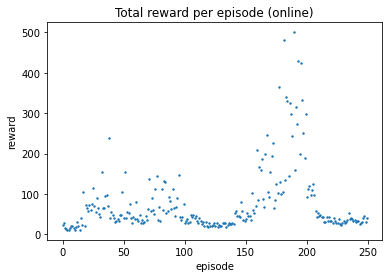

In [8]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

## PPO Agent

<AxesSubplot:>

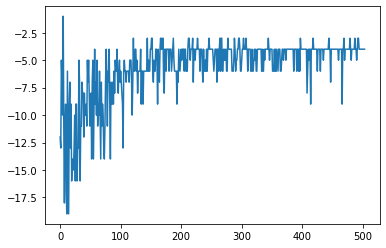

In [9]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
rh = agent.run(env, 500, verbose=False)

pd.Series(rh).plot()

Session: 0
Session: 1
Session: 2


<AxesSubplot:>

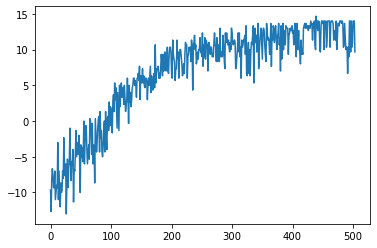

In [10]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

rhs = []
for i in range(3):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 500)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()

Session: 0
Session: 1
Session: 2


<AxesSubplot:>

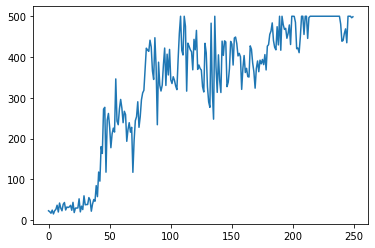

In [11]:
env_names = ['CartPole-v1', 'LunarLander-v2','Acrobot-v1', 'MountainCar-v0']
env = gym.make(env_names[0])
NUM_OBS = env.observation_space.shape[0]
NUM_ACTS = env.action_space.n

rhs = []
for i in range(3):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 250)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()